# Online estimation of curvature and torsion for a contour following task


position data along contour -->  invariants module --> corresponding curvatures  --> model-based particle filter --> progress + filtered curvatures


In [2]:
import numpy as np
import invariants_py.data_handler as dh
from numpy import pi
from numpy.linalg import inv
from mpl_toolkits import mplot3d
%matplotlib inline
import matplotlib.pyplot as plt
import invariants_py.data_handler as dh
import invariants_py.reparameterization as reparam
import scipy.interpolate as ip
from invariants_py.opti_calculate_vector_invariants_position_mf import OCP_calc_pos
from mpl_toolkits.mplot3d import Axes3D


### Load example contour data and reparameterize to arclength


In [3]:
data_location = '../data/sinus.txt'
trajectory,time = dh.read_pose_trajectory_from_txt(data_location)
pose,time_profile,arclength,nb_samples,stepsize = reparam.reparameterize_trajectory_arclength(trajectory)
trajectory = pose[:,0:3,3]

print(stepsize)

0.006578947368421052


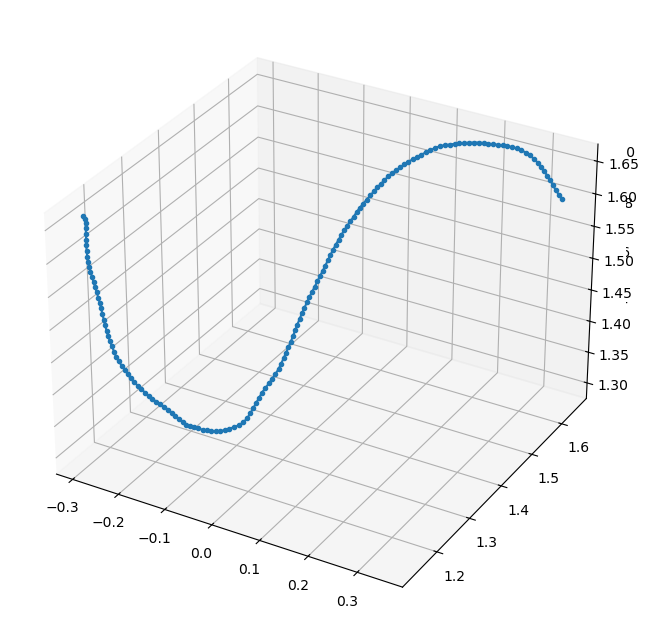

In [4]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
ax = plt.axes(projection='3d')
ax.plot(trajectory[:,0],trajectory[:,1],trajectory[:,2],'.-')


### Calculate global curvature and torsion to later compare with

In [5]:
# specify optimization problem symbolically
FS_calculation_problem = OCP_calc_pos(window_len=nb_samples, bool_unsigned_invariants = False, w_pos = 1, w_deriv = (10**-8)*np.array([10**4, 1.0, 1.0]), w_abs = (10**-5)*np.array([1.0, 1.0]))

# calculate invariants given measurements
invariants, calculate_trajectory, movingframes = FS_calculation_problem.calculate_invariants_global(trajectory,stepsize)



******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:    11823
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     5907

Total number of variables............................:     2277
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:     1821
Total number of inequality c

Visualize calculated trajectory and invariants

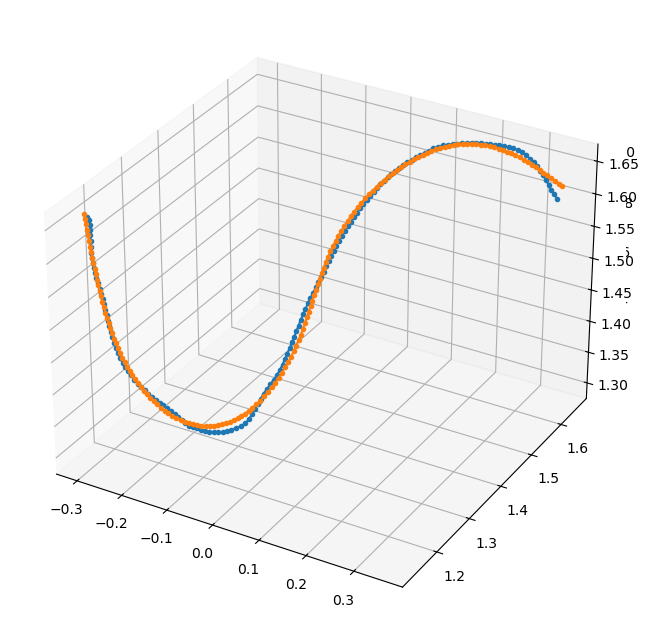

In [6]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
ax = plt.axes(projection='3d')
ax.plot(trajectory[:,0],trajectory[:,1],trajectory[:,2],'.-')
ax.plot(calculate_trajectory[:,0],calculate_trajectory[:,1],calculate_trajectory[:,2],'.-')



Text(0.5, 1.0, 'Torsion [rad/m]')

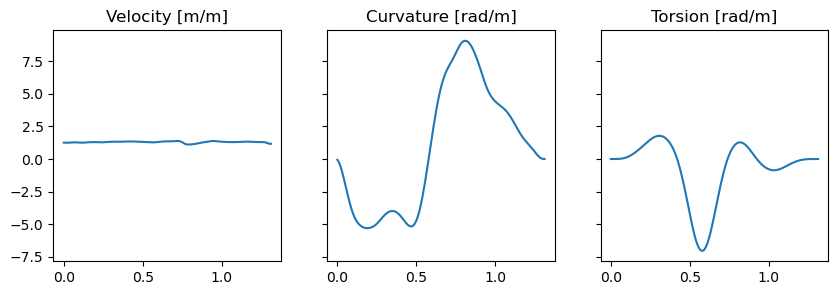

In [7]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True, figsize=(10,3))
ax1.plot(arclength,invariants[:,0])
ax1.set_title('Velocity [m/m]')
ax2.plot(arclength,invariants[:,1])
ax2.set_title('Curvature [rad/m]')
ax3.plot(arclength,invariants[:,2])
ax3.set_title('Torsion [rad/m]')



## Simulation of online measurements

this is to test the online calculation separate from the real application

In [8]:
# Spline of model
knots = np.concatenate(([arclength[0]],[arclength[0]],arclength,[arclength[-1]],[arclength[-1]]))
degree = 3
spline_model_trajectory = ip.BSpline(knots,trajectory,degree)

def simulate_noisy_measurements(model_trajectory, current_progress, stepsize, online_window_len):
    
    noise_std = 0.005*0
    
    progress_values = np.linspace(current_progress, current_progress-online_window_len*stepsize, online_window_len )
    #print(progress_values)
    noisy_measurements = np.array([model_trajectory(i) for i in progress_values]) 

    return noisy_measurements + np.random.randn(online_window_len,3)*noise_std


Testing simulated measurements

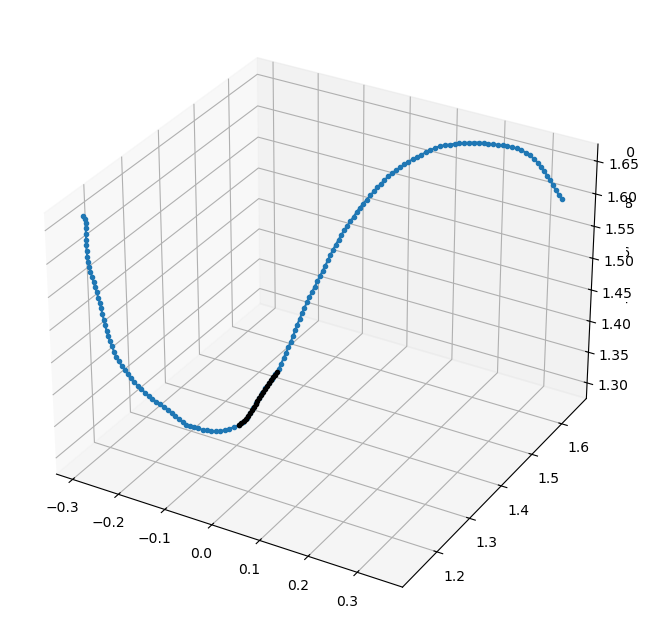

In [9]:
test_measurements = simulate_noisy_measurements(spline_model_trajectory,0.8,0.005,20)

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
ax = plt.axes(projection='3d')
ax.plot(trajectory[:,0],trajectory[:,1],trajectory[:,2],'.-')
ax.plot(test_measurements[:,0],test_measurements[:,1],test_measurements[:,2],'k.-')


## Online estimation of curvature and torsion


In [10]:
from IPython.display import clear_output
import time


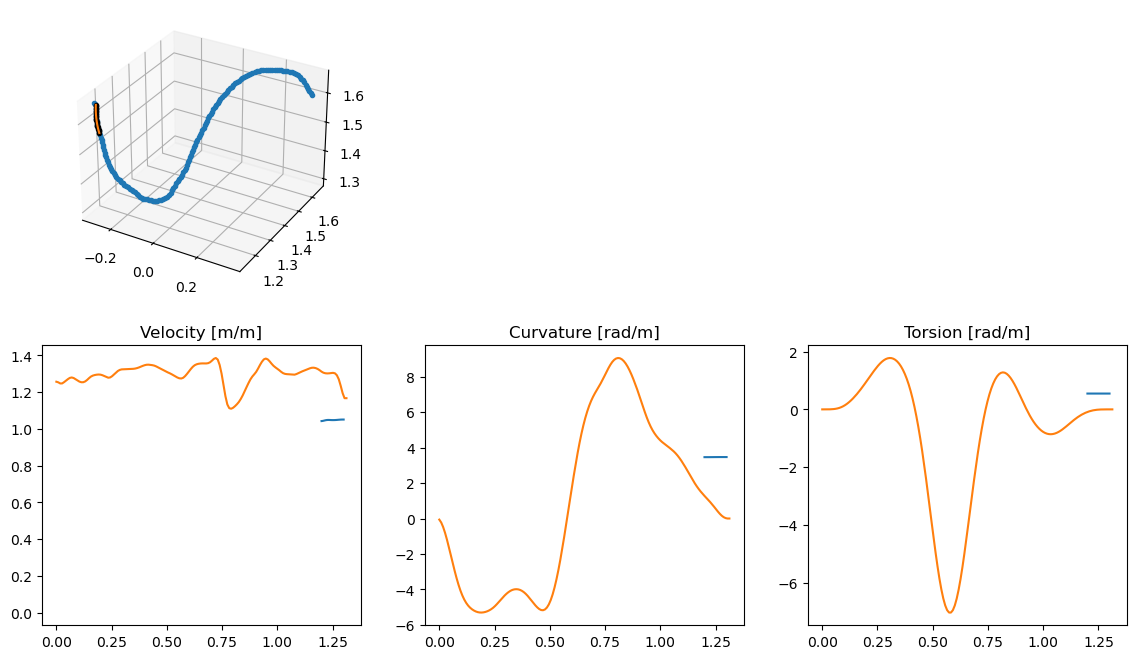

In [11]:
window_len = 20
stepsize = 0.005
window_increment = 10

# specify optimization problem symbolically
FS_online_calculation_problem = OCP_calc_pos(window_len=window_len, bool_unsigned_invariants = False, w_pos = 1, w_deriv = (10**-3)*np.array([1.0, 1.0, 1.0]), w_abs = (10**-8)*np.array([1.0, 1.0]))

# Visualization
current_progress = 0.15
while current_progress <= arclength[-1]:

    #print(f"current progress = {current_progress}")
    measurements = simulate_noisy_measurements(spline_model_trajectory,current_progress,stepsize,window_len)

    # Calculate invariants in window
    invariants_online, trajectory_online, mf = FS_online_calculation_problem.calculate_invariants_online(measurements,stepsize,window_increment)

    # Visualization
    xvector = np.linspace(current_progress-window_len*stepsize, current_progress , window_len)
    
    clear_output(wait=True)
    
#    fig = plt.figure(figsize=(8,8))
#ax = fig.add_subplot(111, projection='3d')

    
    fig = plt.figure(figsize=(14,8))
#    fig = plt.subplot(2,3,1)
    ax = fig.add_subplot(231, projection='3d')
    ax.plot(trajectory[:,0],trajectory[:,1],trajectory[:,2],'.-')
    ax.plot(measurements[:,0],measurements[:,1],measurements[:,2],'k.')
    ax.plot(trajectory_online[:,0],trajectory_online[:,1],trajectory_online[:,2])
    
    plt.subplot(2,3,4)
    plt.plot(xvector,np.abs(invariants_online[:,0]))
    plt.plot(arclength,invariants[:,0])
    plt.plot(0,0)
    plt.title('Velocity [m/m]')
    
    plt.subplot(2,3,5)
    plt.plot(xvector,np.abs(invariants_online[:,1]))
    plt.plot(arclength,invariants[:,1])
    plt.plot(0,0)
    plt.title('Curvature [rad/m]')
    
    plt.subplot(2,3,6)
    plt.plot(xvector,np.abs(invariants_online[:,2]))
    plt.plot(arclength,invariants[:,2])
    plt.plot(0,0)
    plt.title('Torsion [rad/m]')

    plt.show(block=False)
    
    
    current_progress = round(current_progress + window_increment*stepsize,3) # start index next window